# RoBERTa-large to check event relations without context

In [ ]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "0"
import torch
from transformers import AutoTokenizer, AutoModelForMaskedLM

tokenizer = AutoTokenizer.from_pretrained("roberta-large")
model = AutoModelForMaskedLM.from_pretrained("roberta-large").to("cuda")

In [3]:
import torch.nn.functional as F

e1 = "arrest"
e2 = "kill"


relation_token_ids = {"before":tokenizer.encode("before", add_special_tokens=False)[0],
                      "after":tokenizer.encode("after", add_special_tokens=False)[0],
                      "equal":tokenizer.encode("during", add_special_tokens=False)[0]
                    }

with torch.no_grad():
  text = f"{e1} happens {tokenizer.mask_token} {e2}"
  input = tokenizer(text, return_tensors="pt").to("cuda")
  mask_token_index = torch.where(input["input_ids"][0] == tokenizer.mask_token_id)[0]
  token_logits = model(**input).logits
  mask_token_logits = token_logits[0, mask_token_index, :]
  mask_token_softmax = F.softmax(mask_token_logits, dim=1)
  max_idx = torch.argmax(mask_token_softmax[0][[relation_token_ids["before"], relation_token_ids["after"], relation_token_ids["equal"]]])
  pred_relation = list(relation_token_ids.keys())[max_idx]
  print(pred_relation)

after


In [4]:
def zero_shot_mlm(e1, e2):
    with torch.no_grad():
        text = f"{e1} happens {tokenizer.mask_token} {e2}"
        input = tokenizer(text, return_tensors="pt").to("cuda")
        mask_token_index = torch.where(input["input_ids"][0] == tokenizer.mask_token_id)[0]
        token_logits = model(**input).logits
        mask_token_logits = token_logits[0, mask_token_index, :]
        mask_token_softmax = F.softmax(mask_token_logits, dim=1)
        max_idx = torch.argmax(mask_token_softmax[0][[relation_token_ids["before"], relation_token_ids["after"], relation_token_ids["equal"]]])
        pred_relation = list(relation_token_ids.keys())[max_idx]
        return pred_relation

In [7]:
import json
from tqdm import tqdm

features_eval = json.load(open("../data/valid_text_features_matres.json", "r"))

for feat in tqdm(features_eval):
    e1 = feat["e1"]
    e2 = feat["e2"]
    pred_relation = zero_shot_mlm(e1, e2)
    feat["pred_relation"] = pred_relation


100%|██████████| 6404/6404 [04:00<00:00, 26.60it/s]


In [9]:
features_eval = json.load(open("../data/valid_text_features_matres.json", "r"))

num_dict = {0: "before", 1: "after", 2: "equal", 3: "vague"}
pred_2_num = {"before":0, "after":1, "equal":2}

pred = [pred_2_num[feat["pred_relation"]] for feat in features_eval]
labels = [feat["labels"][0] for feat in features_eval]

In [14]:
from sklearn.metrics import accuracy_score, f1_score

accuracy_score(labels, pred), f1_score(labels, pred, average="macro"), f1_score(labels, pred, average="micro")

(0.39693941286695816, 0.21949467496720393, 0.39693941286695816)

### Use this to select eval set. Select those predictions are wrong

In [18]:
roberta_bias_conflict = [i for i, feat in enumerate(features_eval) if pred_2_num[feat['pred_relation']] != feat["labels"][0]]

In [22]:
import numpy as np
with open("../dataset_bias/valid_text_features_matres_roberta_erp_bias.json", "w") as writer:
    json.dump(list(np.array(features_eval)[roberta_bias_conflict]), writer)
numerical_eval_features = json.load(open("../data/valid_features_matres.json", "r"))
with open("../dataset_bias/valid_features_matres_roberta_erp_bias.json", "w") as writer:
    json.dump(list(np.array(numerical_eval_features)[roberta_bias_conflict]), writer)

# 'google/bigbird-roberta-large'

In [23]:
import gc
del model
gc.collect()
tokenizer = AutoTokenizer.from_pretrained('google/bigbird-roberta-large')
model = AutoModelForMaskedLM.from_pretrained('google/bigbird-roberta-large').to("cuda")

Some weights of the model checkpoint at google/bigbird-roberta-large were not used when initializing BigBirdForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BigBirdForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BigBirdForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [24]:
import json
from tqdm import tqdm

# features_eval = json.load(open("../data/valid_text_features_matres.json", "r"))

for feat in tqdm(features_eval):
    e1 = feat["e1"]
    e2 = feat["e2"]
    pred_relation = zero_shot_mlm(e1, e2)
    feat["pred_relation_bigbird"] = pred_relation


100%|██████████| 6404/6404 [04:36<00:00, 23.13it/s]


In [25]:
from sklearn.metrics import accuracy_score, f1_score

pred_bigbird = [pred_2_num[feat["pred_relation_bigbird"]] for feat in features_eval]
accuracy_score(labels, pred_bigbird), f1_score(labels, pred_bigbird, average="macro"), f1_score(labels, pred_bigbird, average="micro")

(0.35446595877576514, 0.14704040903554233, 0.3544659587757651)

In [26]:
bigbird_bias_conflict = [i for i, feat in enumerate(features_eval) if pred_2_num[feat['pred_relation_bigbird']] != feat["labels"][0]]
with open("../dataset_bias/valid_features_matres_bigbird_erp_bias.json", "w") as writer:
    json.dump(list(np.array(numerical_eval_features)[bigbird_bias_conflict]), writer)

In [27]:
# both incorrect

both_bias_conflict = [i for i, feat in enumerate(features_eval) if pred_2_num[feat['pred_relation_bigbird']] != feat["labels"][0] and pred_2_num[feat['pred_relation']] != feat["labels"][0]]
print(len(both_bias_conflict))                      
with open("../dataset_bias/valid_features_matres_both_erp_bias.json", "w") as writer:
    json.dump(list(np.array(numerical_eval_features)[both_bias_conflict]), writer)

2969


# GPT-2

In [3]:
from transformers import AutoModelForCausalLM

tokenizer = AutoTokenizer.from_pretrained('gpt2-large')
tokenizer.add_special_tokens({'pad_token': '[PAD]'})

model =  AutoModelForCausalLM.from_pretrained('gpt2-large').to("cuda")


In [5]:
import json
features_eval = json.load(open("../data/valid_text_features_matres.json", "r"))

num_dict = {0: "before", 1: "after", 2: "equal", 3: "vague"}
pred_2_num = {"before":0, "after":1, "equal":2}

In [55]:
cr_loss = torch.nn.functional.cross_entropy
def get_perplexity(text):
    with torch.no_grad():
        input = tokenizer(text, return_tensors="pt", padding="longest").to("cuda")
        ids = input["input_ids"]
        mask = input["attention_mask"]

        input["labels"] = input["input_ids"]

        outputs = model(**input)

        shift_logits = outputs[1][..., :-1, :].contiguous().view(-1,outputs[1].size(-1))
        shift_labels = ids[..., 1:].contiguous().view(-1)
            
        loss = cr_loss(shift_logits, shift_labels, 
                    ignore_index=tokenizer.pad_token_id, reduction="none").view(ids.size(0), -1)

        loss = torch.div(torch.sum(loss, dim=1), torch.sum(mask[:, 1:], dim=1))

    return loss.cpu().tolist()

In [8]:
temp_rel_relations = {"before":"before", "after":"after", "equal":"during"}
def zero_shot_gpt2(e1, e2):
   with torch.no_grad():
      text = [f"{e1} happens {r} {e2}" for r in temp_rel_relations.values()]
      loss = get_perplexity(text)
      max_idx = np.argmin(loss) # get the smallest loss
      pred_relation = list(temp_rel_relations.keys())[max_idx]
      return pred_relation

In [9]:
e1 = "arrest"
e2 = "kill"
text = [f"{e1} happens {r} {e2}" for r in temp_rel_relations.values()]
input = tokenizer(text, return_tensors="pt", padding="longest").to("cuda")
get_perplexity(text)

[9.072517395019531, 9.05626106262207, 9.474804878234863]

In [11]:
import json
import numpy as np
from tqdm import tqdm

for feat in tqdm(features_eval):
    e1 = feat["e1"]
    e2 = feat["e2"]
    pred_relation = zero_shot_gpt2(e1, e2)
    feat["pred_relation_gpt2"] = pred_relation


100%|██████████| 6404/6404 [04:37<00:00, 23.09it/s]


In [14]:
from sklearn.metrics import accuracy_score, f1_score
labels = [feat["labels"][0] for feat in features_eval]
pred_gpt2 = [pred_2_num[feat["pred_relation_gpt2"]] for feat in features_eval]
accuracy_score(labels, pred_gpt2), f1_score(labels, pred_gpt2, average="macro"), f1_score(labels, pred_gpt2, average="micro")

(0.36961274203622735, 0.21597823874693078, 0.3696127420362274)

In [86]:
pred_gpt2 = [pred_2_num[feat["pred_relation_gpt2"]] for feat in features_eval]
accuracy_score(labels, pred_gpt2), f1_score(labels, pred_gpt2, average="macro"), f1_score(labels, pred_gpt2, average="micro")

(0.36961274203622735, 0.21597823874693078, 0.3696127420362274)

In [ ]:
all_bias_conflict = [i for i, feat in enumerate(features_eval) if pred_2_num[feat['pred_relation_bigbird']] != feat["labels"][0] and pred_2_num[feat['pred_relation']] != feat["labels"][0] and pred_2_num[feat['pred_relation_gpt2']] != feat["labels"][0]]
# with open("../dataset_bias/valid_features_matres_all_erp_bias.json", "w") as writer:
#     json.dump(list(np.array(numerical_eval_features)[all_bias_conflict]), writer)
with open("../dataset_bias/valid_text_features_matres_all_erp_bias.json", "w") as writer:
    json.dump(list(np.array(features_eval)[all_bias_conflict]), writer)

In [17]:
gpt2_conflict = [i for i, feat in enumerate(features_eval) if pred_2_num[feat['pred_relation_gpt2']] != feat["labels"][0]]
with open("../dataset_bias/valid_text_features_matres_gpt2_erp_bias.json", "w") as writer:
    json.dump(list(np.array(features_eval)[gpt2_conflict]), writer)

# GPT2-xl

In [19]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
from transformers import AutoTokenizer, AutoModelForCausalLM

tokenizer = AutoTokenizer.from_pretrained('gpt2-xl')
tokenizer.add_special_tokens({'pad_token': '[PAD]'})

model =  AutoModelForCausalLM.from_pretrained('gpt2-xl').to("cuda")
model.resize_token_embeddings(len(tokenizer))

Embedding(50258, 1600)

In [2]:
import json
import torch
import json
import numpy as np
from tqdm import tqdm

features_eval = json.load(open("../data/valid_text_features_matres.json", "r"))

num_dict = {0: "before", 1: "after", 2: "equal", 3: "vague"}
pred_2_num = {"before":0, "after":1, "equal":2}

cr_loss = torch.nn.functional.cross_entropy
def get_perplexity(text):
    with torch.no_grad():
        input = tokenizer(text, return_tensors="pt", padding="longest").to("cuda")
        ids = input["input_ids"]
        mask = input["attention_mask"]

        input["labels"] = input["input_ids"].detach().clone()

        outputs = model(**input)

        shift_logits = outputs[1][..., :-1, :].contiguous().view(-1,outputs[1].size(-1))
        shift_labels = ids[..., 1:].contiguous().view(-1)
            
        loss = cr_loss(shift_logits, shift_labels, 
                    ignore_index=tokenizer.pad_token_id, reduction="none").view(ids.size(0), -1)

        loss = torch.div(torch.sum(loss, dim=1), torch.sum(mask[:, 1:], dim=1))

    return loss.cpu().tolist()

temp_rel_relations = {"before":"before", "after":"after", "equal":"during"}
def zero_shot_gpt2(e1, e2):
   with torch.no_grad():
      text = [f"{e1} happens {r} {e2}" for r in temp_rel_relations.values()]
      loss = get_perplexity(text)
      max_idx = np.argmin(loss) # get the smallest loss
      pred_relation = list(temp_rel_relations.keys())[max_idx]
      return pred_relation
def zero_shot_gpt2_softmax(e1, e2):
   with torch.no_grad():
      text = [f"{e1} happens {r} {e2}" for r in temp_rel_relations.values()]
      loss = get_perplexity(text)
      max_idx = np.argmin(loss) # get the smallest loss
      pred_relation = list(temp_rel_relations.keys())[max_idx]
      return pred_relation

In [3]:
features_eval = json.load(open("../data/valid_subset_text.json", "r"))

In [ ]:
# 1. simple perplexity
for feat in tqdm(features_eval):
    e1 = feat["e1"]
    e2 = feat["e2"]
    pred_relation = zero_shot_gpt2(e1, e2)
    feat["pred_relation_gpt2_xl"] = pred_relation


In [20]:
# 2. get new probabilities


for feat in tqdm(features_eval):

    e1 = feat["e1"]
    e2 = feat["e2"]
    text = [f"{e1} happens {r} {e2}" for r in temp_rel_relations.values()] + [f"{e2} happens {r} {e1}" for r in temp_rel_relations.values()]
    ppls = get_perplexity(text)
    p = {
        "before": np.exp(-ppls[0]) + np.exp(-ppls[4]),
        "after": np.exp(-ppls[1]) + np.exp(-ppls[3]),
        "equal": np.exp(-ppls[2]) + np.exp(-ppls[5])
    }
    feat["ppls_gpt2_xl"] = json.dumps(p)
    


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:26<00:00, 11.50it/s]


In [15]:
def get_pred_ppl(feat):
    return sorted(json.loads(feat["ppls_gpt2_xl"]).items(), key=lambda x:x[1], reverse=True)[0][0]

In [23]:
gpt2xl_pred = [pred_2_num[get_pred_ppl(feat)] for feat in features_eval]
labels = [feat["labels"][0] for feat in features_eval]

In [25]:
# original accuracy
from sklearn.metrics import f1_score, accuracy_score, classification_report

print("original")
print(f1_score(labels, gpt2xl_pred, average='macro'), f1_score(labels, gpt2xl_pred, average="micro"))


original
0.19001982690285615 0.34


In [26]:
gpt2xl_subset_idx = [i for i in range(len(labels)) if gpt2xl_pred[i]!=labels[i]]
np.save("gpt2xl_subset_idx", gpt2xl_subset_idx)

In [45]:
gpt2xl_subset_idx_hard = [i for i in range(len(labels)) \
                if gpt2xl_pred[i]!=labels[i] and sorted(features_eval[i]["gpt2xl_ppl_norm"].values())[-1] - sorted(features_eval[i]["gpt2xl_ppl_norm"].values())[0] > 0.15]
print(len(gpt2xl_subset_idx_hard))
np.save("gpt2xl_subset_idx_hard", gpt2xl_subset_idx_hard)


148


In [31]:
for feat in tqdm(features_eval):
    feat["gpt2xl_ppl_norm"] = dict([(key, val/sum(json.loads(feat["ppls_gpt2_xl"]).values()) ) for key, val in json.loads(feat["ppls_gpt2_xl"]).items()])
    

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 25696.93it/s]


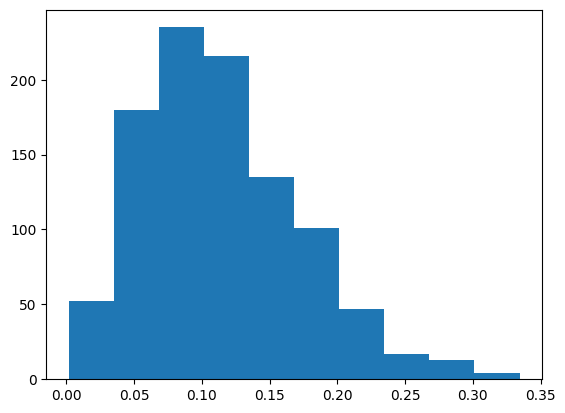

In [39]:
from matplotlib import pyplot as plt
plt.hist([sorted(features_eval[i]["gpt2xl_ppl_norm"].values())[-1] - sorted(features_eval[i]["gpt2xl_ppl_norm"].values())[0] for i in range(len(features_eval))] )
plt.show()

### training set

In [47]:
# training set

train_features_text = json.load(open("../data/train_text_features_matres.json"))

for feat in tqdm(train_features_text):

    e1 = feat["e1"]
    e2 = feat["e2"]
    text = [f"{e1} happens {r} {e2}" for r in temp_rel_relations.values()] + [f"{e2} happens {r} {e1}" for r in temp_rel_relations.values()]
    ppls = get_perplexity(text)
    p = {
        "before": np.exp(-ppls[0]) + np.exp(-ppls[4]),
        "after": np.exp(-ppls[1]) + np.exp(-ppls[3]),
        "equal": np.exp(-ppls[2]) + np.exp(-ppls[5])
    }
    feat["ppls_gpt2_xl"] = json.dumps(p)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6336/6336 [08:56<00:00, 11.81it/s]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6336/6336 [00:00<00:00, 40965.52it/s]


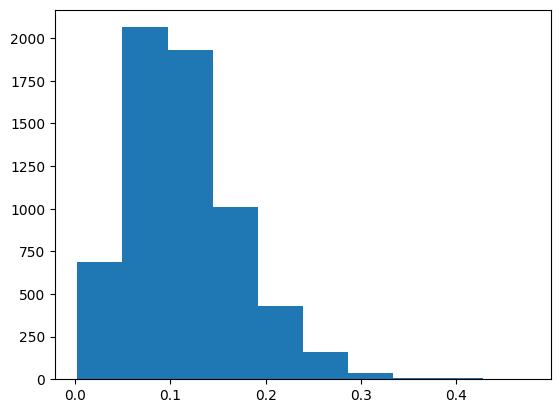

In [50]:
for feat in tqdm(train_features_text):
    feat["gpt2xl_ppl_norm"] = dict([(key, val/sum(json.loads(feat["ppls_gpt2_xl"]).values()) ) for key, val in json.loads(feat["ppls_gpt2_xl"]).items()])
    

plt.hist([sorted(train_features_text[i]["gpt2xl_ppl_norm"].values())[-1] - sorted(train_features_text[i]["gpt2xl_ppl_norm"].values())[0] for i in range(len(train_features_text))] )
plt.show()

In [51]:
labels_train = [feat["labels"][0] for feat in train_features_text]
gpt2xl_pred_train = [pred_2_num[get_pred_ppl(feat)] for feat in train_features_text]

gpt2xl_subset_idx_hard_train = [i for i in range(len(train_features_text)) \
                if gpt2xl_pred_train[i]!=labels_train[i] and sorted(train_features_text[i]["gpt2xl_ppl_norm"].values())[-1] - sorted(train_features_text[i]["gpt2xl_ppl_norm"].values())[0] > 0.15]
print(len(gpt2xl_subset_idx_hard_train))
np.save("gpt2xl_subset_idx_hard_train", gpt2xl_subset_idx_hard_train)


875
